

## Setting Up the Environment

In this cell, we're installing a number of important Python packages that we'll need throughout this notebook. These packages are all part of the broader Python scientific computing ecosystem, and are widely used in machine learning and data science.

1. **PyTorch** (`torch`): This is the main package we'll be using. PyTorch is a popular machine learning library which provides a wide range of features for building and training neural networks. It has strong GPU acceleration support and is used by many researchers in the field.

2. **Torchvision** (`torchvision`): This package is a part of the PyTorch project. It provides useful utilities for working with image data, including pre-trained models, datasets, and image transformation tools.

3. **PyTorch Lightning** (`pytorch-lightning`): This is a wrapper around PyTorch that simplifies a lot of the boilerplate code we often find ourselves writing. It structures your PyTorch code in a way that is consistent and makes it easier to do things like distributed training and automatic mixed precision.

4. **PyTorch Lightning Bolts** (`pytorch-lightning-bolts`): Bolts is an extension of PyTorch Lightning that provides a number of pre-made models, datasets, and other utilities. It's great for getting a quick start with new projects.

5. **NumPy** (`numpy`): This is a fundamental package for scientific computing in Python. It provides a powerful N-dimensional array object and functions for working with these arrays.

6. **Pandas** (`pandas`): This package provides high-performance, easy-to-use data structures and data analysis tools. We'll be using it for data manipulation and analysis.

7. **Matplotlib** (`matplotlib`): This is a plotting library for Python and its numerical mathematics extension NumPy. We'll use it to create graphs and visualize our data and results.

8. **OpenCV** (`opencv-python`): This is an open source computer vision and machine learning software library. We'll use it for processing and manipulating images.

9. **Scikit-Learn** (`scikit-learn`): This is a powerful library for machine learning in Python. It provides a selection of efficient tools for machine learning and statistical modeling including classification, regression, clustering and dimensionality reduction via a consistence interface in Python.

10. **TensorBoardX** (`tensorboardX`): This package lets you use TensorBoard with PyTorch, TensorFlow's visualization toolkit. It's great for visualizing training progress, debugging, and optimizing your models.

11. **TensorBoard** (`tensorboard`): TensorBoard provides the visualization and tooling needed for machine learning experimentation. You can track and visualize metrics such as loss and accuracy, visualize the model graph, view histograms, display images, and much more.

Running the `!pip install` command installs these packages so that they can be imported and used in Python programs. The exclamation point at the beginning of the line is a special Jupyter command that allows us to run command-line instructions from inside a notebook. 

---

In the next cell, we'll start importing these packages and using them to build our machine learning model.

In [1]:
!pip install torch torchvision pytorch-lightning pytorch-lightning-bolts torchmetrics tensorboard-plugin-profile
!pip install numpy pandas matplotlib opencv-python scikit-learn tensorboardX tensorboard tqdm seaborn
%matplotlib inline

**Importing Libraries**

This cell imports all the necessary libraries we'll be using in this notebook.

- **Standard library**:
  - `os`: This module provides a portable way of using operating system dependent functionality.

- **Third-party libraries**:
  - `numpy` and `pandas`: These are fundamental packages for scientific computing and data manipulation in Python.
  - `matplotlib.pyplot`: This library is used for creating static, animated, and interactive visualizations in Python.
  - `PIL.Image`: The Python Imaging Library adds image processing capabilities to your Python interpreter.
  - `sklearn.model_selection.train_test_split`: This function is a quick utility that wraps input validation and next(ShuffleSplit().split(X, y)) and application to input data into a single call for splitting data in a oner.
  - `sklearn`: Scikit-learn is a free software machine learning library for the Python programming language.

- **PyTorch and related libraries**:
  - `torch`, `torchvision`, `torch.nn`, `torch.utils.data`, `torch.optim`: These are libraries from PyTorch used for building neural networks, data loading, and optimization.
  
- **PyTorch Lightning**:
  - `pytorch_lightning`: PyTorch Lightning is a lightweight PyTorch wrapper for high-performance AI research. It organizes your code base, decouples your research into four intuitive categories while providing full flexibility with all the benefits of PyTorch, reducing the boilerplate so you can focus on the key parts of your code.

- **Printing versions**: This ensures we know the versions of the libraries we are working with. Having this information is valuable for reproducibility and debugging.

In [2]:
# Standard library
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import random
import warnings

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # <-- Sklearn metrics
from tqdm import tqdm

# PyTorch and related libraries
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam

# torchvision
import torchvision
from torchvision import transforms, models
from torchvision.models import densenet121, DenseNet121_Weights 


# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, DeviceStatsMonitor, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

# Torchmetrics
import torchmetrics  
from torchmetrics import MeanSquaredError, MeanAbsoluteError  
torch.set_float32_matmul_precision("high")

# Print versions
print(f"Torchvision: {torchvision.__version__}")
print(f"PyTorch Lightning: {pl.__version__}")  # <--- TYPO FIX
print(f"Torch: {torch.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Torchmetrics: {torchmetrics.__version__}")  # <--- Print torchmetrics version


Torchvision: 0.15.2+cu117
PyTorch Lightning: 2.0.3
Torch: 2.0.1+cu117
Numpy: 1.23.5
Pandas: 2.0.2
Torchmetrics: 0.11.4


**Setting up Constants**

This cell defines all the constants that will be used throughout the notebook.

- **Path to data**:
  - `DATA_DIR`: This is the directory where your data is stored.
  - `KEY_DATA_DIR`: This directory contains key slices of the dataset.
  - `CSV_PATH`: This is the path to the CSV file which contains labels for the images.

- **Image settings**:
  - `IMAGE_SIZE`: We resize all images to this size. Many pre-trained models, like ResNet, expect this input size.
  - `NUM_CLASSES`: This denotes the number of unique classes or labels in our dataset.

- **Normalization constants for ImageNet**:
  - `IMAGENET_MEAN` and `IMAGENET_STD`: These are normalization constants used for ImageNet. We will use these constants to normalize our own dataset as the model we are using (ResNet) was trained on ImageNet.

- **Training settings**:
  - `BATCH_SIZE`: This is the number of samples that will be propagated through the network at one time.
  - `EPOCHS`: This is the number of complete passes through the entire training dataset.
  - `LEARNING_RATE`: This controls how much to change the model in response to the estimated error each time the model weights are updated.
  - `TRAIN_SPLIT`: This is the proportion of data to use for training. The rest will be used for validation.

- **CPU settings**:
  - `CPU_CORES`: The number of CPU cores to use for data loading.

- **Optimizer settings**:
  - `OPTIMIZER`: This is the optimization algorithm used to change the attributes of the neural network such as weights and learning rate to reduce the losses.

Lastly, we print out these constants to make sure they are set correctly.

In [3]:
# Constants

# Path to data
DATA_DIR: str = os.path.join(os.getcwd(), 'data/Images_png')
KEY_DATA_DIR: str = os.path.join(os.getcwd(), 'data/Key_slices')
CSV_PATH: str = os.path.join(os.getcwd(), 'data/DL_info.csv')  # The path to the CSV file containing the labels

# Image settings
IMAGE_SIZE: int = 224  # We will resize all images to this size. ResNet, for example, expects this input size
NUM_CLASSES: int = 4   # the bounding box

# Assume the grayscale images have been standardized to have values between 0 and 1
GRAYSCALE_MEAN = 0.5
GRAYSCALE_STD = 0.5

# Training settings
BATCH_SIZE: int = 32  # The batch size for training and validation
EPOCHS: int = 100  # The number of epochs for training. Adjust based on your observation of the model performance
LEARNING_RATE: float = 1e-3  # Learning rate for the optimizer. This may need to be adjusted based on the model's performance
TRAIN_SPLIT: float = 0.8  # The proportion of data to use for training. The rest will be used for validation
CPU_CORES: int = 8

# Optimizer settings
OPTIMIZER: str = 'Adam'  # The optimizer to use. You can change this to 'SGD' or other optimizers as needed

print(DATA_DIR)
print(KEY_DATA_DIR)
print(CSV_PATH)
print(BATCH_SIZE)
print(EPOCHS)
print(OPTIMIZER)

/home/jbourne/projects/bourne/reagan/deep_lesion/data/Images_png
/home/jbourne/projects/bourne/reagan/deep_lesion/data/Key_slices
/home/jbourne/projects/bourne/reagan/deep_lesion/data/DL_info.csv
32
100
Adam


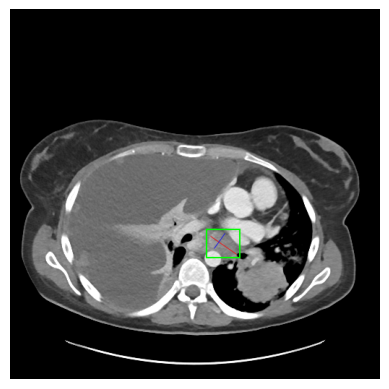

In [4]:
def bbox_iou(box1, box2):
    """
    Returns the IoU of two bounding boxes.

    Parameters:
    box1 (tensor): A tensor containing bounding box coordinates in the format (x1, y1, x2, y2)
    box2 (tensor): A tensor containing bounding box coordinates in the format (x1, y1, x2, y2)

    Returns:
    float: IoU of box1 and box2
    """

    # Obtain the intersection coordinates
    x1 = torch.max(box1[..., 0], box2[..., 0])
    y1 = torch.max(box1[..., 1], box2[..., 1])
    x2 = torch.min(box1[..., 2], box2[..., 2])
    y2 = torch.min(box1[..., 3], box2[..., 3])

    # Compute the area of intersection
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    # Compute the area of both bounding boxes
    box1_area = (box1[..., 2] - box1[..., 0]) * (box1[..., 3] - box1[..., 1])
    box2_area = (box2[..., 2] - box2[..., 0]) * (box2[..., 3] - box2[..., 1])

    # Compute the IoU
    iou = intersection / (box1_area + box2_area - intersection + 1e-6)
    
    return iou


def visualize_and_print_stats(image):
    """Display an image and print its min, max, mean, and std."""
    plt.imshow(image)
    plt.show()

    print(f"Image min: {image.min()}")
    print(f"Image max: {image.max()}")
    print(f"Image mean: {image.mean()}")
    print(f"Image std: {image.std()}")

class To3Channels(object):
    """Convert a 1-channel grayscale image to a 3-channel image by duplicating the channel three times."""
    def __call__(self, image):
        return image.repeat(3, 1, 1)

# Get the list of images
images = os.listdir(KEY_DATA_DIR)

# Choose a random image
image = random.choice(images)

# Load the image
path = os.path.join(KEY_DATA_DIR, image)

# Show the image
image = Image.open(path)

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

**Defining the Model**

This is the main section where we define our model. In this case, we're using a technique known as **transfer learning**, which is a method where a pre-trained model is adapted for a new, different data problem. Here we use the **ResNet50** model, which is a convolutional neural network that is 50 layers deep, pre-trained on the ImageNet dataset.

In the following sections, we will discuss each part of the `DeepLesionModel` class.

- **`__init__`**: This is the initialization function where we define our model architecture and loss function.
  - We initialize a pre-trained ResNet50 model.
  - We replace the last layer (fully connected layer) of ResNet50 to match the number of classes in our problem (`num_classes`). This is because the original ResNet50 was trained on a dataset with 1,000 classes, but we only have 10 classes.
  - We define our loss function to be cross entropy loss, which is commonly used for multi-class classification problems.
  - We also set the learning rate and optimizer type, which will be used in training the model.

- **`forward`**: This function defines the forward pass of the network, which simply calls the forward pass of the ResNet50 model.

- **`training_step`**: This function defines what happens in each step of the training. For each batch, it computes the model's predictions (`logits`), calculates the loss between the predictions and the actual labels (`y`), logs the loss, and returns it.

- **`validation_step`**: This function is similar to `training_step`, but is used during the validation phase. In addition to computing and returning the loss, it also adds each batch's loss to `self.val_losses`.

- **`on_validation_epoch_end`**: This function is called at the end of each validation epoch. It calculates the average validation loss over all batches, logs it, and resets `self.val_losses`.

- **`configure_optimizers`**: This function defines the optimizer that will be used to train the model. It supports both SGD and Adam optimizers.

The overall architecture of our model is based on ResNet50, but adapted to our specific task. It is important to note that deep learning models are highly flexible, and this architecture can be further modified and tuned to better fit the data and the problem at hand.

In the context of **deep learning**, ResNet, or Residual Network, is a type of Convolutional Neural Network (CNN) architecture that was designed to enable hundreds or thousands of convolutional layers. While traditional neural networks would become impossible to train effectively as depth increases, ResNet mitigates this by introducing "skip" or "shortcut" connections (also known as residual connections) that allow the model to learn an identity function that ensures the higher layer will perform at least as well as the lower layer, and not worse.

In [5]:
class DeepLesionModel(pl.LightningModule):
    def __init__(self, learning_rate=LEARNING_RATE, batch_size=32):
        super().__init__()

        # Base model (DenseNet121)
        self.base_model = densenet121(weights=DenseNet121_Weights.DEFAULT)
        num_features = self.base_model.classifier.in_features

        # Replace the fully connected layer for bounding box regression
        self.base_model.classifier = torch.nn.Linear(num_features, 4)

        # Hyperparameters
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # metrics
        self.mae = torchmetrics.MeanAbsoluteError()
        self.mape = torchmetrics.MeanAbsolutePercentageError()
        self.smape = torchmetrics.SymmetricMeanAbsolutePercentageError()
        self.mlse = torchmetrics.MeanSquaredLogError()

        # placeholders for losses
        self.training_step_outputs = []
        self.validation_step_outputs = []

    def forward(self, x):
        return self.base_model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        loss = F.smooth_l1_loss(y_hat, y)
        self.log('train_loss', loss)
        self.training_step_outputs.append(loss)
        
        # Calculate metrics on the train set
        self.log("train_mae", self.mae(y_hat, y))
        self.log("train_mape", self.mape(y_hat, y))
        self.log("train_smape", self.smape(y_hat, y))
        self.log("train_mlse", self.mlse(y_hat, y))
    
        iou = bbox_iou(y_hat, y).mean()
        self.log('train_iou', iou)
    
        return loss

    def on_train_epoch_end(self):
        epoch_average = torch.stack(self.training_step_outputs).mean()
        self.log("train_loss_epoch", epoch_average)
        self.training_step_outputs.clear()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.smooth_l1_loss(y_hat, y)
        self.log('val_loss', val_loss)
        self.validation_step_outputs.append(val_loss)
        
        # Calculate metrics on the validation set
        self.log("val_mae", self.mae(y_hat, y))
        self.log("val_mape", self.mape(y_hat, y))
        self.log("val_smape", self.smape(y_hat, y))
        self.log("val_mlse", self.mlse(y_hat, y))

        iou = bbox_iou(y_hat, y).mean()
        self.log('val_iou', iou)

        return val_loss

    def on_validation_epoch_end(self):
        epoch_average = torch.stack(self.validation_step_outputs).mean()
        self.log("val_loss_epoch", epoch_average)
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        test_loss = F.smooth_l1_loss(y_hat, y)
        self.log('test_loss', test_loss)

        # Calculate metrics on the test set
        self.log("test_mae", self.mae(y_hat, y))
        self.log("test_mape", self.mape(y_hat, y))
        self.log("test_smape", self.smape(y_hat, y))
        self.log("test_mlse", self.mlse(y_hat, y))
        
        iou = bbox_iou(y_hat, y).mean()
        self.log('test_iou', iou)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    
    def prepare_data(self):
        # Prepare the datasets here
        full_dataset = pd.read_csv(CSV_PATH)  # replace with the path to your dataset
    
        train_df = full_dataset[full_dataset['Train_Val_Test'] == 1]
        val_df = full_dataset[full_dataset['Train_Val_Test'] == 2]
        test_df = full_dataset[full_dataset['Train_Val_Test'] == 3]
    
        self.train_dataset = DeepLesionDataset(
            image_dir=KEY_DATA_DIR, 
            df=train_df, 
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([GRAYSCALE_MEAN], [GRAYSCALE_STD])
            ])
        )
        
        self.val_dataset = DeepLesionDataset(
            image_dir=KEY_DATA_DIR, 
            df=val_df, 
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([GRAYSCALE_MEAN], [GRAYSCALE_STD])
            ])
        )
        
        self.test_dataset = DeepLesionDataset(
            image_dir=KEY_DATA_DIR, 
            df=test_df, 
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([GRAYSCALE_MEAN], [GRAYSCALE_STD])
            ])
        )

        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=CPU_CORES)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=CPU_CORES)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=CPU_CORES)


**Defining the Dataset**

Machine Learning models learn from data. In PyTorch, we often use `Dataset` and `DataLoader` classes to manage our data, divide it into batches, shuffle it, and allow for multi-threaded data loading.

Here, we define a `DeepLesionDataset` class that inherits from `torch.utils.data.Dataset`. This class is responsible for loading the images and their corresponding labels from disk. Let's discuss each part:

- **`__init__`**: This function is called when we create a new instance of the class. We pass in the image directory, a pandas DataFrame containing the metadata of the dataset (such as file names and labels), and any image transformations we want to apply.

- **`__len__`**: This function returns the total number of samples in our dataset. It's used by PyTorch to determine the number of steps per epoch.

- **`__getitem__`**: This function is called to get the sample and label at a particular index. We:
  - Open the image file and convert it to a 16-bit grayscale image.
  - Apply a linear transformation to convert the pixel values to Hounsfield Units (used in medical imaging to quantify radiodensity), which improves the contrast in the images.
  - Apply DICOM windowing: DICOM is a standard used in medical imaging. Different tissues (like bones, blood, etc.) have different ranges of Hounsfield Units. Windowing allows us to focus on a specific range, which enhances the visibility of certain tissues over others.
  - Clip the image pixel values to lie within the DICOM window and scale them to range from 0 to 255.
  - Convert the image to a PIL Image object and apply any transformations.
  - Retrieve the label from the DataFrame, adding 1 because our lesion types are from -1 to 8 and we need them to be from 0 to 9.

**Note**: The specific preprocessing and transformations applied to the images are due to the nature of medical imaging data. Different types of data would require different preprocessing steps.

In [6]:
class ResizeAndAdjustBbox(object):
    """Resizes the image and adjusts the bounding box coordinates accordingly."""
    def __init__(self, size):
        self.size = size

    def __call__(self, sample):
        image, bbox = sample
        w, h = image.size
        new_w, new_h = self.size

        # Resize the image
        image = transforms.Resize(self.size)(image)

        # Adjust the bounding box coordinates
        bbox = [bbox[0]*new_w/w, bbox[1]*new_h/h, bbox[2]*new_w/w, bbox[3]*new_h/h]

        return image, torch.tensor(bbox)

class DeepLesionDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, df, transform=None):
        self.image_dir = image_dir
        self.df = df
        self.transform = transform
        self.resize_and_adjust_bbox = ResizeAndAdjustBbox((IMAGE_SIZE, IMAGE_SIZE))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['File_name'])
    
        # Load the image as grayscale
        image = Image.open(img_path).convert('L')
        image = np.array(image, dtype=np.uint8)
        image = Image.fromarray(image)  # Convert back to PIL image
    
        # Get bounding box
        bbox = list(map(float, row['Bounding_boxes'].split(',')))
    
        # Apply the resize and adjust bbox transform
        image, bbox = self.resize_and_adjust_bbox((image, bbox))
    
        # Apply other transformations if any
        if self.transform:
            image = self.transform(image)
        
        return image, bbox



**Defining the DataModule**

While the `Dataset` class in PyTorch is responsible for how to load a single sample, `DataModule` in PyTorch Lightning is a more high-level construct. It organizes all data loading and preparation steps, and it's compatible with the Lightning Trainer for maximum convenience. 

Our `DeepLesionDataModule` class inherits from `pl.LightningDataModule`. Let's break down the parts:

- **`__init__`**: When creating a new instance, we pass in the path to the data directory, the path to the CSV file with labels, the image transformations, and the batch size.

- **`setup`**: This method is called to prepare the data for use. Here, we create our training and validation datasets. We use a DataFrame loaded from the CSV file and create two new DataFrames for training and validation data based on the 'Train_Val_Test' column. Then, we use these DataFrames to instantiate our `DeepLesionDataset` for training and validation.

- **`train_dataloader` and `val_dataloader`**: These methods return the DataLoaders that will be used for training and validation, respectively. They use the `DataLoader` class from PyTorch to combine the dataset into batches and allow for multi-threaded or multi-process data loading.

In the next part of the cell, we define a custom transform class `To3Channels` that converts a 1-channel grayscale image to a 3-channel image by duplicating the channel three times. We need this because the ResNet model we are using is designed for 3-channel RGB images.

The `transforms.Compose` function allows us to chain multiple transformations together. We resize the image to match the input size expected by our model, convert it to a tensor, duplicate the grayscale channel to make it a 3-channel image, and normalize it using the mean and standard deviation values of ImageNet (since our ResNet model was pre-trained on ImageNet).

Finally, we instantiate our `DeepLesionDataModule` with the appropriate parameters and call `setup()` to prepare our data for training.

In [7]:


# Define DataModule
class DeepLesionDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, csv_path, batch_size=BATCH_SIZE):
        super().__init__()
        self.data_dir = data_dir
        self.csv_path = csv_path
        self.batch_size = batch_size
    
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Convert image to PyTorch tensor
            To3Channels(),  # Expand to 3 channels
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
        ])


    def setup(self, stage=None):
        # Instantiate the full dataset
        full_dataset = pd.read_csv(self.csv_path)

        # Filter rows to create training, validation and testing datasets based on the 'Train_Val_Test' column
        train_df = full_dataset[full_dataset['Train_Val_Test'] == 1]
        val_df = full_dataset[full_dataset['Train_Val_Test'] == 2]
        test_df = full_dataset[full_dataset['Train_Val_Test'] == 3]

        # Create the train, val and test datasets
        self.train_dataset = DeepLesionDataset(self.data_dir, train_df, transform=self.transform)
        self.val_dataset = DeepLesionDataset(self.data_dir, val_df, transform=self.transform)
        self.test_dataset = DeepLesionDataset(self.data_dir, test_df, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=8)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=8)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=8)

# Instantiate the datamodule
data_module = DeepLesionDataModule(KEY_DATA_DIR, CSV_PATH)
data_module.setup()

**Defining Callbacks**

A *callback* is a piece of code that can be specified to be executed at certain stages of the training process, such as at the start or end of an epoch, on batch start or end, etc. PyTorch Lightning provides a variety of built-in callbacks for common uses.

Here we are configuring four types of callbacks:

- **EarlyStopping**: This callback monitors a specified metric (in this case, the validation loss), and stops the training process when the metric stops improving. This is useful to prevent overfitting. We have set a patience of 3, which means training will stop if the validation loss does not improve for 3 consecutive epochs. The `mode="min"` argument indicates that improvement is defined as a decrease in the metric value.

- **ModelCheckpoint**: This callback saves the model weights at certain intervals. We are monitoring the validation loss and saving the weights of the model whenever the validation loss reaches a new minimum. We specify a directory to save the checkpoints and a filename template that includes the epoch number and validation loss. The `save_top_k=3` argument means that the best 3 models (with the lowest validation loss) will be saved.

- **DeviceStatsMonitor**: This callback logs device (GPU or CPU) usage statistics such as memory and utilization during training. This can be useful to track resource usage, identify bottlenecks, and ensure that the training process is making efficient use of the available hardware.

- **LearningRateMonitor**: This callback logs the learning rate for TensorBoard. This is useful if you're using a learning rate scheduler that changes the learning rate during training, as you can see how the learning rate changes and how it correlates with other metrics like loss.

These callbacks are passed to the `Trainer` when it is instantiated, and they are called at the appropriate times during training.

In [8]:
# Filter out the specific UserWarning related to the checkpoint directory
warnings.filterwarnings(
    action='ignore',
    category=UserWarning,
    module='pytorch_lightning.callbacks.model_checkpoint',
    message='.*Checkpoint directory.*exists and is not empty.*',
)

# Configure early stopping
early_stop_callback = EarlyStopping(
    monitor="val_loss", # or the metric of your choice
    min_delta=0.001,
    patience=3,
    verbose=True,
    mode="min"
)

# Configure model checkpointing
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss", # or the metric of your choice
    dirpath=".training_checkpoints",
    filename="model-{epoch:02d}-{val_loss:.2f}", # or use a custom template of your choice
    save_top_k=3,
    mode="min",
)

device_stats_callback = DeviceStatsMonitor()

learning_rate_callback = LearningRateMonitor()


**Launching TensorBoard**

TensorBoard is a powerful tool that provides a range of functionalities for visualizing deep learning models, metrics, and more. It's designed to help you understand, debug, and optimize your model by displaying scalars, images, text, graphs, histograms, etc.

In this cell, we are doing two things:

- The `%load_ext tensorboard` magic command loads the TensorBoard extension for Jupyter notebooks. It's a one-time setup step that allows us to launch TensorBoard inside the notebook.

- The `%tensorboard --logdir ./tb_logs` magic command actually starts TensorBoard. The `--logdir` argument specifies the directory where TensorBoard should look for log files to display. We've logged our training and validation metrics to this directory using the `TensorBoardLogger` when we defined our `Trainer`.

So, with just two lines of code, we're starting a comprehensive real-time visualization suite right inside our notebook! As your model trains, you'll be able to track its performance, view the learning curves, analyze the gradient flow, understand your model architecture, and much more. TensorBoard can be an invaluable tool in your machine learning toolkit.

In [9]:
%load_ext tensorboard
%tensorboard --logdir ./tb_logs

Reusing TensorBoard on port 6006 (pid 24059), started 15:47:55 ago. (Use '!kill 24059' to kill it.)

-
In this final cell, we're putting together everything we've built and defined in the previous steps to actually train our neural network model.

First, we instantiate our `DeepLesionModel` which we defined earlier. We specify the number of lesion classes and the learning rate as arguments. These are defined as constants at the top of the notebook. 

Next, we define a `Trainer` using PyTorch Lightning. This is where a lot of the magic happens. The `Trainer` abstracts away a lot of the boilerplate training code you would usually write when using vanilla PyTorch. Here are the components we define for our `Trainer`:

1. `max_epochs`: The maximum number of complete passes through the training dataset before stopping the training process.

2. `callbacks`: These are special functions that the `Trainer` will call at specific points during training. We include the early stopping and model checkpointing callbacks we defined earlier, along with device stats and learning rate monitoring.

3. `accelerator`, `strategy`, and `devices`: These are configurations for how PyTorch Lightning should distribute the computation. Setting these to "auto" allows PyTorch Lightning to make the best decision based on your available hardware.

4. `logger`: This is for logging training/validation metrics and parameters to a format that can be visualized in TensorBoard. We point it to a directory called `tb_logs` and give our training run a name: "deep_lesion".

Finally, we call `trainer.fit(model, data_module)` to kick off the training process. This will start the process of running our images through the model, adjusting the model's weights based on the output, and repeating this process across the number of epochs we've specified. During this process, you can watch the training and validation loss values (a measure of how well the model is performing) go down, hopefully indicating that our model is learning to classify lesion types from our images.

In [10]:
# Instantiate the model
model = DeepLesionModel(learning_rate=LEARNING_RATE)

# Define PyTorch Lightning trainer
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[
        early_stop_callback,
        checkpoint_callback,
        device_stats_callback,
        learning_rate_callback,
    ],
    accumulate_grad_batches=4,
    precision='16-mixed',
    accelerator="auto",
    strategy="auto",
    devices="auto",
    logger=TensorBoardLogger("tb_logs", name="deep_lesion") # Use TensorBoard to log the metrics
)

torch.cuda.empty_cache()

# Train the model
trainer.fit(model, data_module)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                                 | Params
--------------------------------------------------------------------
0 | base_model | DenseNet                             | 7.0 M 
1 | mae        | MeanAbsoluteError                    | 0     
2 | mape       | MeanAbsolutePercentageError          | 0     
3 | smape      | SymmetricMeanAbsolutePercentageError | 0     
4 | mlse       | MeanSquaredLogError                  | 0     
--------------------------------------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
27.832    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 18.155


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 11.195 >= min_delta = 0.001. New best score: 6.960


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.560 >= min_delta = 0.001. New best score: 5.400


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.867 >= min_delta = 0.001. New best score: 4.533


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.011 >= min_delta = 0.001. New best score: 3.522


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.340 >= min_delta = 0.001. New best score: 3.181


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.058 >= min_delta = 0.001. New best score: 3.124


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.114 >= min_delta = 0.001. New best score: 3.010


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.337 >= min_delta = 0.001. New best score: 2.673


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.250 >= min_delta = 0.001. New best score: 2.422


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 2.422. Signaling Trainer to stop.


In [11]:
# Test the model
trainer.test(model, datamodule=data_module)

# Access the logged test metrics
print(f"Test MAE: {trainer.logged_metrics['test_mae']}")
print(f"Test MAPE: {trainer.logged_metrics['test_mape']}")
print(f"Test SMAPE: {trainer.logged_metrics['test_smape']}")
print(f"Test MLSE: {trainer.logged_metrics['test_mlse']}")
print(f"Test IoU: {trainer.logged_metrics['test_iou']}")


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_iou          │    0.6383103132247925     │
│         test_loss         │    2.7120518684387207     │
│         test_mae          │    3.1259396076202393     │
│         test_mape         │    0.03319576382637024    │
│         test_mlse         │   0.009523134678602219    │
│        test_smape         │   0.030729999765753746    │
└───────────────────────────┴───────────────────────────┘

Test MAE: 3.1259396076202393
Test MAPE: 0.03319576382637024
Test SMAPE: 0.030729999765753746
Test MLSE: 0.009523134678602219
Test IoU: 0.6383103132247925


In [12]:
def imshow(inp, targets=None, predictions=None, title=None):
    """Display image for Tensor."""
    # Add 3 channels to the grayscale image by repeating
    if inp.shape[0] == 1:
        inp = inp.repeat(3, 1, 1)
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    # Start a new plot
    fig, ax = plt.subplots(1)
    
    ax.imshow(inp)
    if title is not None:
        plt.title(title)
    
    if targets is not None:
        # Draw ground truth bounding box
        gt_rect = patches.Rectangle((targets[0], targets[1]), targets[2], targets[3], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(gt_rect)
    
    if predictions is not None:
        # Draw predicted bounding box
        pred_rect = patches.Rectangle((predictions[0], predictions[1]), predictions[2], predictions[3], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(pred_rect)
    
    plt.axis('off')  # Remove axes
    plt.pause(0.001)  # pause a bit so that plots are updated


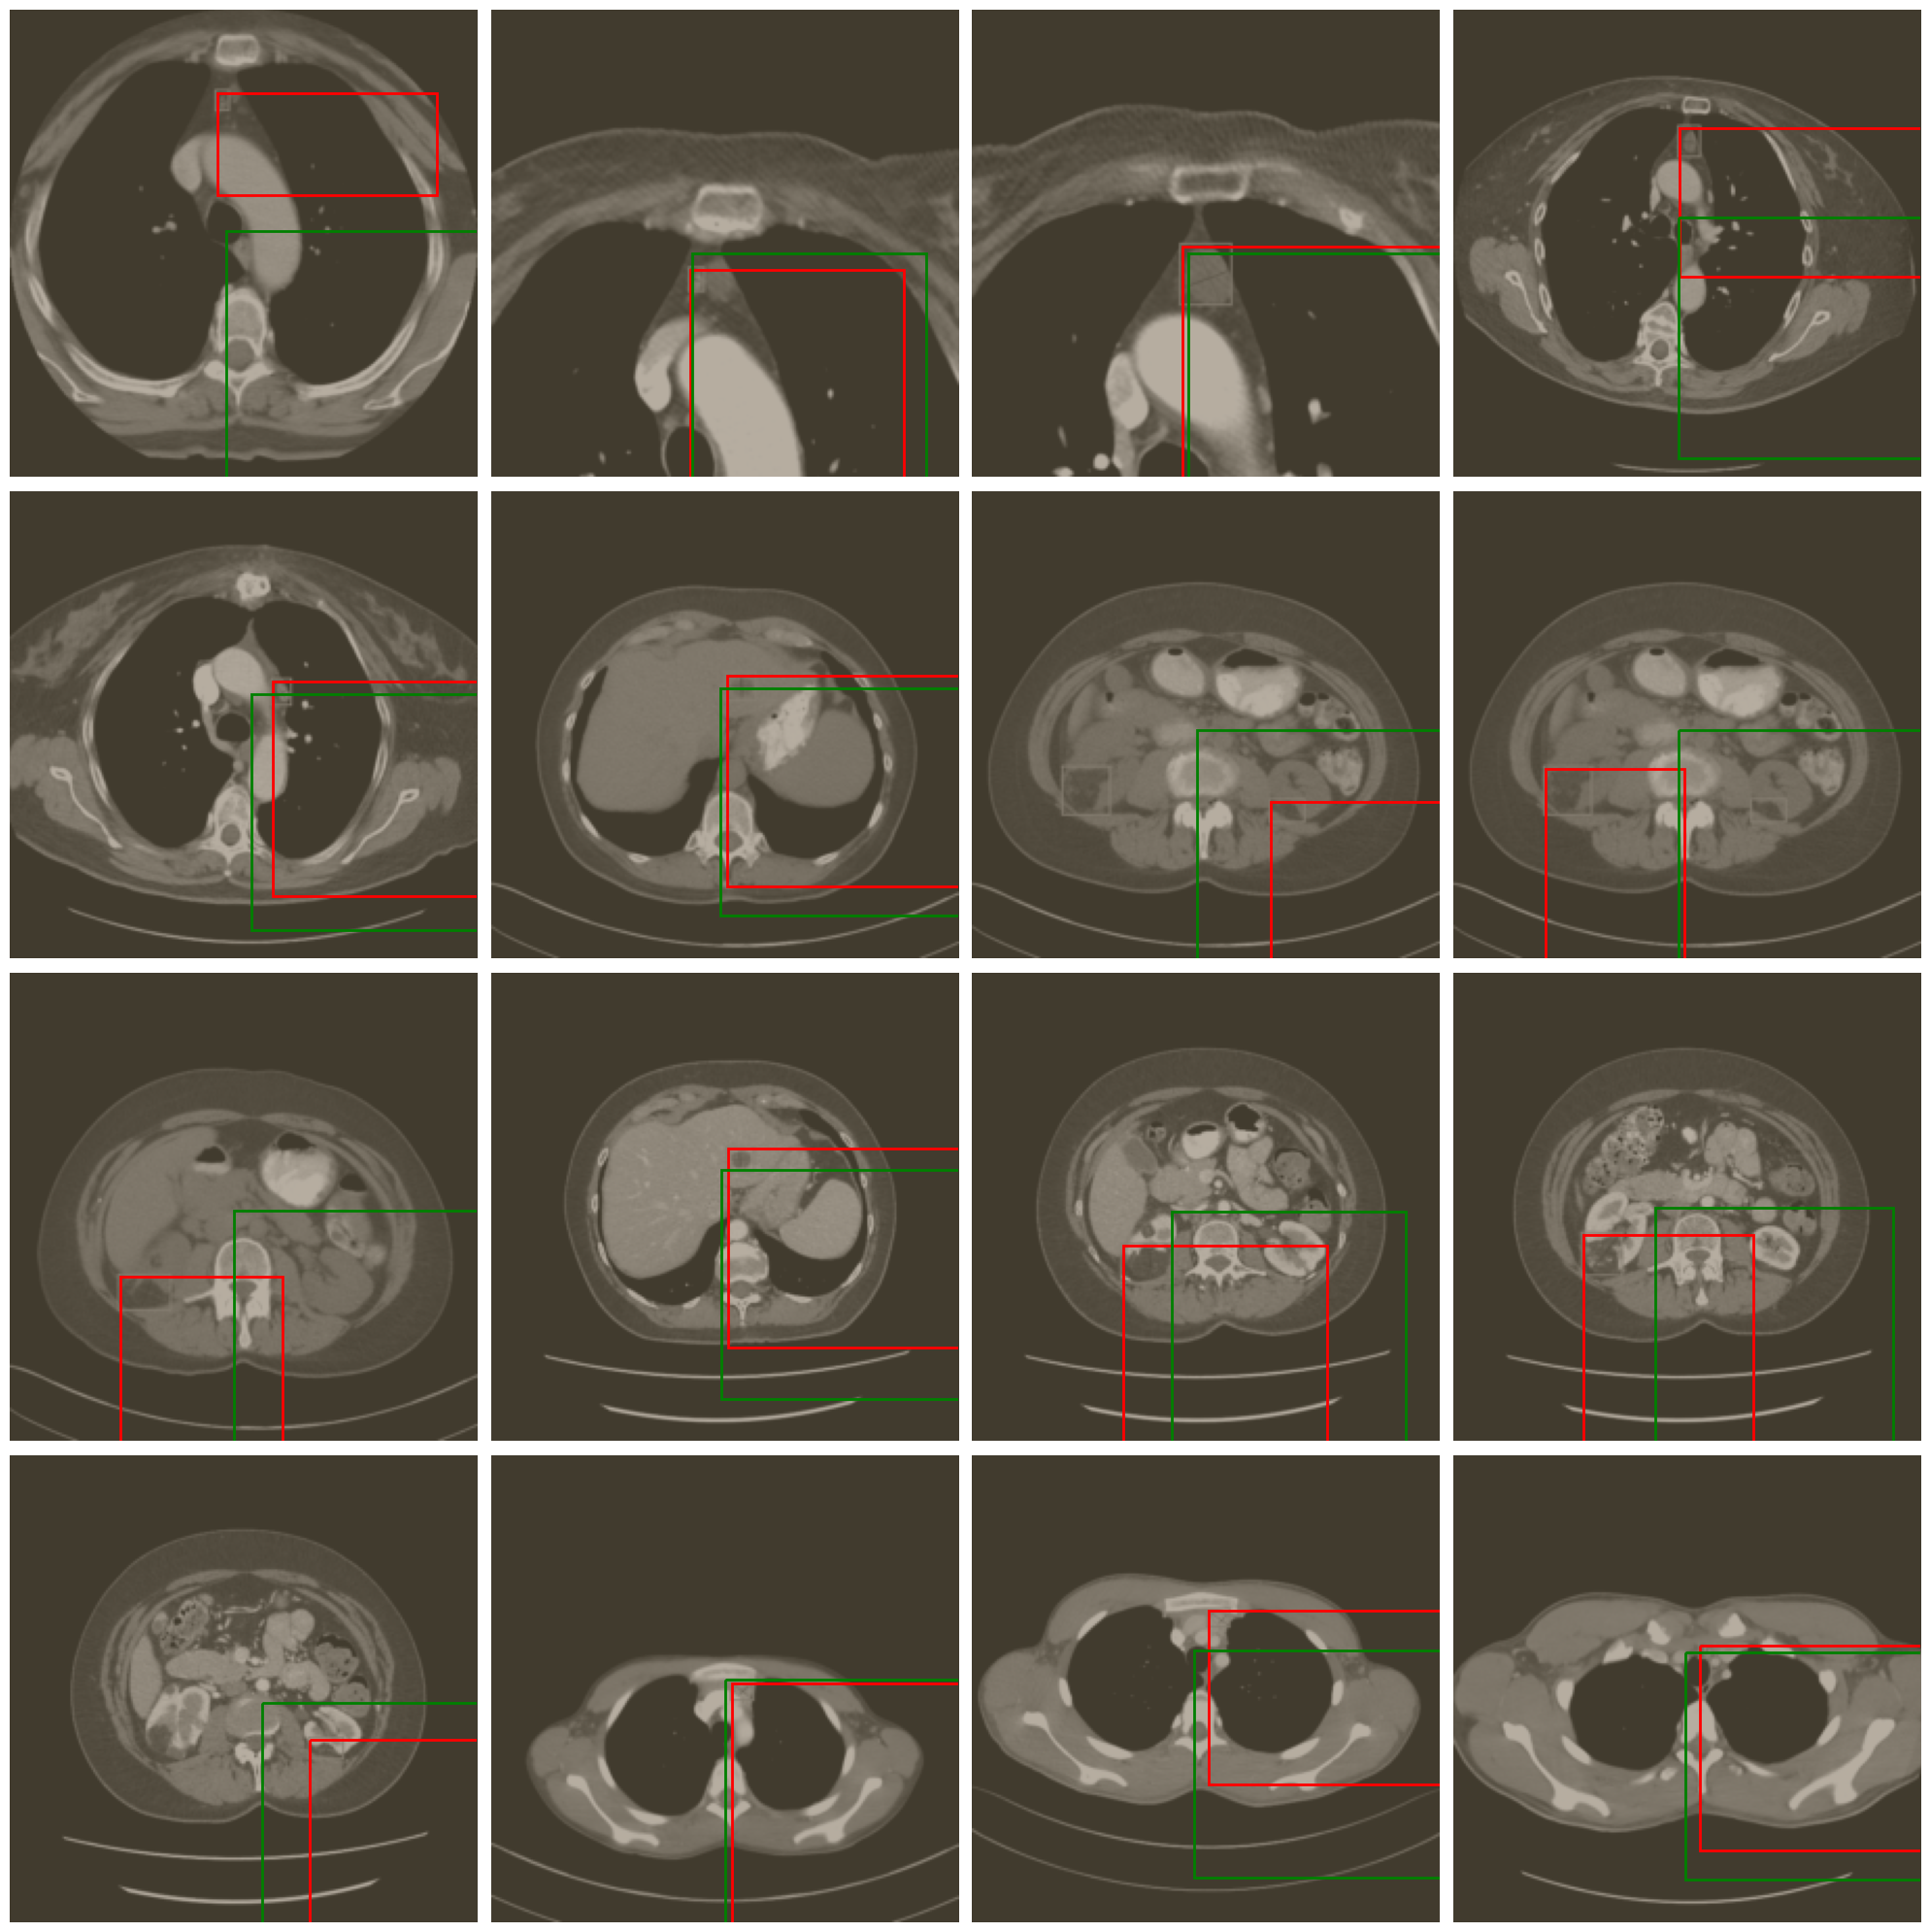

In [13]:
# Get a batch of test data
inputs, classes = next(iter(model.test_dataloader()))

fig, axs = plt.subplots(4, 4, figsize=(20, 20))  # Create a 4x4 grid of subplots
axs = axs.ravel()  # Flatten the grid to easily index into it

for i in range(16):  # Display 16 images
    img = inputs[i]
    if img.shape[0] == 1:
        img = img.expand((3, -1, -1))
    # Compute predictions
    with torch.no_grad():
        predictions = model(img.unsqueeze(0)).squeeze(0)
    
    # Convert tensor to numpy array for display
    inp = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    # Display the image in the subplot
    axs[i].imshow(inp)
    axs[i].axis('off')  # Hide the axes for this subplot

    # Draw ground truth bounding box
    gt_rect = patches.Rectangle((classes[i][0], classes[i][1]), classes[i][2], classes[i][3], linewidth=2, edgecolor='r', facecolor='none')
    axs[i].add_patch(gt_rect)
    
    # Draw predicted bounding box
    pred_rect = patches.Rectangle((predictions[0], predictions[1]), predictions[2], predictions[3], linewidth=2, edgecolor='g', facecolor='none')
    axs[i].add_patch(pred_rect)

plt.tight_layout()  # Ensure the subplots do not overlap
plt.show()


In [14]:
print(model)

DeepLesionModel(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, m